# CS 109A/AC 209A/STAT 121A Data Science: Homework 6
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 2nd, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW6.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
#from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Last, First]

### Part (b): Course Number

[CS 109a or STATS 121a or AC 209a]

### Part (c): Who did you work with?

[First and Land names of students with whom you have collaborated]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Recommender System for Movies

In this problem, you will build a model to recommend movies using ratings from users. 

The dataset for this problem is contained in `dataset_4_ratings.txt`. This dataset contains ratings from 100 users for 1000 movies. The first two columns contain the user and movie IDs. The last column contains a 1 if the user liked the movie, and 0 otherwise. Not every movie is rated by every user (i.e. some movies have more ratings than others).

The names of the movies corresponding to the IDs are provided in `dataset_4_movie_names.txt`.

### Part 1(a): Exploring how to rank

One way of recommending movies is to recommend movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?


- **Implementation:** Suppose we measure the "goodness" of a movie by the probability that it will be liked by a user, $P(\textbf{label} = \text{like}|\textbf{movie}) = \theta_{\text{movie}}$. Assuming that each user independently rates a given movie according to the probability $\theta_{\text{movies}}$. Use a reasonable estimate of $\theta_{\text{movies}}$ to build a list of top 25 movies that you would recommend to a new user.

   **Hint:** What does the likelihood function, $P(\textbf{likes} = k | \theta_{\text{movie}}, n, \textbf{movie})$, look like? What $\theta_{\text{movie}}$ will maximize the likelihood?
   

- **Analysis:** Why is using $\theta_{\text{movie}}$ to rank movies more appropriate than using the total number of likes? Explain why your estimate of $\theta_{\text{movie}}$ is reasonable. Explain the potential draw backs of estimating $\theta_{\text{movie}}$ this way.

   **Hint:** Under what conditions may models that maximize the likelihood be suboptimal? Do those conditions apply here?   

In [3]:
ratings_df = pd.read_csv('datasets/dataset_4_ratings.txt', delimiter=',')
print ratings_df.head()

   user_id  movie_id  rating
0     22.0     377.0     0.0
1     62.0     257.0     0.0
2     95.0     546.0     0.0
3     38.0      95.0     1.0
4     63.0     277.0     1.0


In [4]:
names_df = pd.read_csv('datasets/dataset_4_movie_names.txt', delimiter='|')
print names_df.head()

   movie_id         movie_name release_date  Unnamed: 3  \
0         1   Toy Story (1995)  01-Jan-1995         NaN   
1         2   GoldenEye (1995)  01-Jan-1995         NaN   
2         3  Four Rooms (1995)  01-Jan-1995         NaN   
3         4  Get Shorty (1995)  01-Jan-1995         NaN   
4         5     Copycat (1995)  01-Jan-1995         NaN   

                                                link  Unnamed: 5  Unnamed: 6  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...           0           0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...           0           1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...           0           0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...           0           1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)           0           0   

   Unnamed: 7  Unnamed: 8  Unnamed: 9     ...       Unnamed: 15  Unnamed: 16  \
0           0           1           1     ...                 0            0   
1   

### Step 2: Implement a simple ranking system

One way of recommending movies is to recommend movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?

Suppose that we simple count the number of likes for each movie and take the 25 movies with the most number of likes. Would this be a good idea?

To help you extract the movie information from the two databases, we have built you a helper function.

In [5]:
#--------  movie_stats
# A function that extracts the number of likes and total number of ratings for a movie
# Input: 
#      movie_name (an optional parameter containing the exact name of the movie)
#      movie_name_contains (an optional parameter containing a portion of the name of the movie)
# Returns: 
#      total_ratings (the total number of ratings for a movie)
#      likes (the total number of likes for a movie)

def movie_stats(movie_name=None, movie_name_contains=None):
    
    #If given an exact movie name:
    if movie_name is not None:        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains)].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes

In [6]:
total_ratings, likes = movie_stats(movie_name_contains='Toy Story')

print 'total number of ratings for Toy Story:', total_ratings
print 'number of likes for Toy Story:', likes

total number of ratings for Toy Story: 51.0
number of likes for Toy Story: 38.0


In [7]:
total_ratings, likes = movie_stats(movie_name_contains="Shawshank Redemption")

print 'total number of ratings for Star Wars:', total_ratings
print 'number of likes for Star Wars:', likes

total number of ratings for Star Wars: 39.0
number of likes for Star Wars: 39.0


In [8]:
total_ratings, likes = movie_stats(movie_name_contains='French Twist')

print 'total number of ratings for French Twist:', total_ratings
print 'number of likes for French Twist:', likes

total number of ratings for French Twist: 2.0
number of likes for French Twist: 2.0


Clearly, not all movies have the same number of ratings. Now, if we want to rank the movies by the total number of likes, we'd have to rank "Toy Story" and "Shawshank Redemption" as similarly likable. Does this seem fair to you? Meaning, does our ranking reflect the likability of the movie based on the complete ratings information?

### Step 3: Implement a fairer ranking system

Now, instead of using the total number of likes, we use the total percentage of likes to rank the movies. Why is total like-percentage a more reasonable metric for likability than total number of likes? There is an intuitive, layman's explanation for this choice and there is a formal probabilistic way of justifying this choice.

So what does the top 25 movies loook like when we rank by like-percentage?

In [10]:
#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, likes / total_ratings))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
French Twist (Gazon maudit) (1995) : 1.0 (2.0/2.0)
Exotica (1994) : 1.0 (2.0/2.0)
Three Colors: Red (1994) : 1.0 (12.0/12.0)
Three Colors: White (1994) : 1.0 (8.0/8.0)
Shawshank Redemption, The (1994) : 1.0 (39.0/39.0)
Brother Minister: The Assassination of Malcolm X (1994) : 1.0 (1.0/1.0)
Carlito's Way (1993) : 1.0 (4.0/4.0)
Robert A. Heinlein's The Puppet Masters (1994) : 1.0 (2.0/2.0)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) : 1.0 (2.0/2.0)
Wallace & Gromit: The Best of Aardman Animation (1996) : 1.0 (6.0/6.0)
Maya Lin: A Strong Clear Vision (1994) : 1.0 (1.0/1.0)
Unhook the Stars (1996) : 1.0 (1.0/1.0)
Wrong Trousers, The (1993) : 1.0 (14.0/14.0)
Godfather: Part II, The (1974) : 1.0 (18.0/18.0)
Ridicule (1996) : 1.0 (5.0/5.0)
Pillow Book, The (1995) : 1.0 (2.0/2.0)
When the Cats Away (Chacun cherche son chat) (1996) : 1.0 (3.0/3.0)
unknown : 1.0 (2.0/2.0)
Once Upon a Time... When We Were Colored (1995) : 1.0 (2.0/2.0)
Ass

### Part 1(b): Exploring the effect of prior beliefs

Let's add a prior, $p(\theta_{\text{movie}})$, to our probabilistic model for movie rating. To keep things simple, we will restrict ourselves to using beta priors.

- **Analysis:** How might adding a prior to our model benifit us in our specific task? Why are beta distributions appropriate priors for our application?

  **Hint:** Try visualizing beta priors $a = b = 1$, $a = b = 0.5$, $a = b = 2$ and $a = 4, b = 2$, for example, what kind of plain-English prior beliefs about the movie does each beta pdf encode?


- **Implementation/Analysis:** How does the choice of prior affect the posterior distribution of the 'likability' for the movies: *Toy Story, Star Wars, The Shawshank Redemption, Down Periscope and Chain Reaction*.

   **Hint:** Use our posterior sampling function to visualize the posterior distribution.
   
 
- **Implementation/Analysis:** How does the effect of the prior on the posterior distribution vary with the number of user ratings? 

   **Hint:** Visualize the posterior distribution for different sizes of subsample of user ratings for the movie *Star Wars*.
   
In the following, we've provide you a couple of functions for visualize beta priors and approximating their associated posteriors.

In [13]:
#--------  plot_beta_prior
# A function to visualize a beta pdf on a set of axes
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      color (color of beta pdf)
#      ax (axes on which to plot pdf)
# Returns: 
#      ax (axes with plot of beta pdf)

def plot_beta_prior(a, b, color, ax):
    rv = sp.stats.beta(a, b)
    x = np.linspace(0, 1, 100)
    ax.plot(x, rv.pdf(x), '-', lw=2, color=color, label='a=' + str(a) + ', b=' + str(b))
    ax.set_title('Beta prior with a=' + str(a) + ', b=' + str(b))
    ax.legend(loc='best')
    return ax

In [14]:
#--------  sample_posterior
# A function that samples points from the posterior over a movie's 
# likability, given a binomial likelihood function and beta prior
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      likes (the number of likes in likelihood)
#      ratings (total number of ratings in likelihood)
#      n_samples (number of samples to take from posterior)
# Returns: 
#      post_samples (a array of points from the posterior)

def sample_posterior(a, b, likes, ratings, n_samples):
    post_samples = np.random.beta(a + likes, b + ratings - likes, n_samples)
    return post_samples

In [11]:
#--------  find_mode
# A function that approximates the mode of a distribution given a sample from the distribution
# Input: 
#      values (samples from the distribution)
#      num_bins (number of bins to use in approximating histogram)
# Returns: 
#      mode (the approximate mode of the distribution)

def find_mode(values, num_bins):
    
    #Make an approximation (histogram) of the distribution using the samples
    bins, edges = np.histogram(values, bins=num_bins)
    #Find the bin in the histogram with the max height
    max_height_index = np.argmax(bins)
    #Find the sample corresponding to the bin with the max height (the mode)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    
    return mode

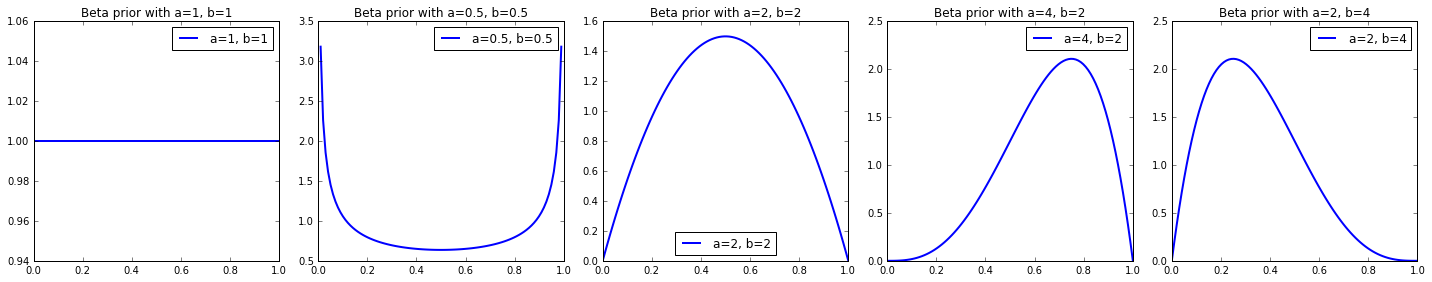

In [15]:
#A list of beta distribution shapes to try out
beta_shapes = [(1, 1), (0.5, 0.5), (2, 2), (4, 2), (2, 4)]
#Length of the list of shapes
n = len(beta_shapes)

#Plot all the beta pdfs in a row
fig, ax = plt.subplots(1, n, figsize=(20, 4))

#Start the index of the current subplot at 0
ax_ind = 0
#Iterate through all the shapes
for a, b in beta_shapes:
    #Plot the beta pdf for a particular shape
    plot_beta_prior(a, b, 'blue', ax[ax_ind])
    #Increment the subplot index
    ax_ind += 1
    
plt.tight_layout()    
plt.show() 

French Twist (Gazon maudit) (1995): 1.0 (2.0/2.0)


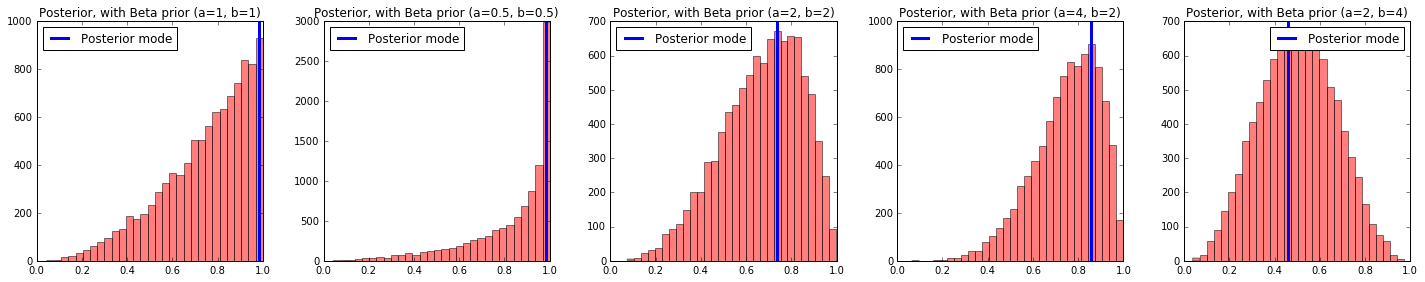

French Twist (Gazon maudit) (1995): 1.0 (2.0/2.0)


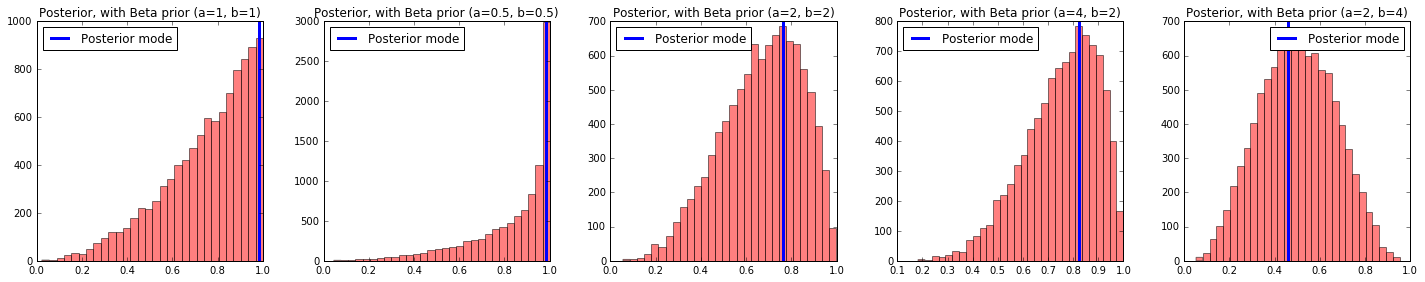

In [16]:
#Get the name of the first movie in the top 25 list
movie_name = top_25_movies[0][0]

#Get the ratings info for the first movie in the top 25 list
likes = top_25_movies[0][1]
total_ratings = top_25_movies[0][2]
likability = top_25_movies[0][3]

#Print movie info
print '{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings)

#Number of samples to use when approximating our posterior
n_samples = 10000

#Plot the posterior corresponding to each prior
fig, ax = plt.subplots(1, n, figsize=(20, 4))

#Start the index of the current subplot at 0
ax_ind = 0

#Iterate through all the shapes
for a, b in beta_shapes:   
    #Draw samples from the posterior corresponding to a particular beta prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
    #Approximate the posterior with a histogram of these samples
    ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)
    #Find the approximate mode of the posterior
    mode = find_mode(post_samples, 30)
    #Plot the mode as a vertical line
    ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')
    
    #Set title, legends etc
    ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
    ax[ax_ind].legend(loc='best')
    #Increment the subplot index
    ax_ind += 1

plt.tight_layout()
plt.show() #Get the name of the first movie in the top 25 list
movie_name = top_25_movies[0][0]

#Get the ratings info for the first movie in the top 25 list
likes = top_25_movies[0][1]
total_ratings = top_25_movies[0][2]
likability = top_25_movies[0][3]

#Print movie info
print '{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings)

#Number of samples to use when approximating our posterior
n_samples = 10000

#Plot the posterior corresponding to each prior
fig, ax = plt.subplots(1, n, figsize=(20, 4))

#Start the index of the current subplot at 0
ax_ind = 0

#Iterate through all the shapes
for a, b in beta_shapes:   
    #Draw samples from the posterior corresponding to a particular beta prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
    #Approximate the posterior with a histogram of these samples
    ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)
    #Find the approximate mode of the posterior
    mode = find_mode(post_samples, 30)
    #Plot the mode as a vertical line
    ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')
    
    #Set title, legends etc
    ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
    ax[ax_ind].legend(loc='best')
    #Increment the subplot index
    ax_ind += 1

plt.tight_layout()
plt.show() 

### Part 1(c): Recommendation based on ranking

- **Implementation:** Choose a reasonable beta prior, choose a reasonable statistic to compute from the posterior, and then build a list of top 25 movies that you would recommend to a new user based on your chosen posterior statistic.  

 
- **Analysis:** How does your top 25 movies compare with the list you obtained in part(a)? Which method of ranking is better?

 
- **Analysis:** So far, our estimates of the 'likability' for a movie was based on the ratings provided by all users. What can be the draw back of this method? How can we improve the recommender system for individual users (if you feel up to the challenge, implement your improved system and compare it to the one you built in the above)? 

In [17]:
#Choose a beta prior that encodes a reasonable belief about likability 
a = 2 
b = 2

#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Approximate the posterior given the ratings info and the prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
    #Approximate posterior mode
    mode = find_mode(post_samples, 30)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, mode))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
Shawshank Redemption, The (1994) : 0.977340047744 (39.0/39.0)
Godfather: Part II, The (1974) : 0.946898539803 (18.0/18.0)
Glory (1989) : 0.945935337708 (17.0/17.0)
Cool Hand Luke (1967) : 0.945335661628 (20.0/20.0)
Three Colors: Red (1994) : 0.94489060715 (12.0/12.0)
Manchurian Candidate, The (1962) : 0.944142155151 (17.0/17.0)
Raiders of the Lost Ark (1981) : 0.941060720056 (47.0/49.0)
Vertigo (1958) : 0.927838821644 (22.0/23.0)
Casablanca (1942) : 0.92719288082 (22.0/23.0)
Third Man, The (1949) : 0.926046280387 (9.0/9.0)
Wrong Trousers, The (1993) : 0.925213178783 (14.0/14.0)
Killing Fields, The (1984) : 0.922172806693 (14.0/14.0)
Three Colors: White (1994) : 0.920372237687 (8.0/8.0)
East of Eden (1955) : 0.9162616655 (8.0/8.0)
Close Shave, A (1995) : 0.912490450251 (16.0/17.0)
High Noon (1952) : 0.912205563132 (11.0/11.0)
Usual Suspects, The (1995) : 0.909863569064 (27.0/29.0)
Local Hero (1983) : 0.90941230381 (10.0/10.0)
Alien (1979) : 0.9

---

## Problem 2: Predicting Urban Demographic Changes

### Part 2(a): Temporal patterns in urban demographics

In this problem you'll work with some neighborhood demographics of a region in Boston from the years 2000 to 2010. 

The data you need are in the files `dataset_1_year_2000.txt`, ..., `dataset_1_year_2010.txt`. The first two columns of each dataset contain the adjusted latitude and longitude of some randomly sampled houses. The last column contains economic status of a household: 

0: low-income, 

1: middle-class, 

2: high-income 

Due to the migration of people in and out of the city, the distribution of each economic group over this region changes over the years. The city of Boston estimates that in this region there is approximately a 25% yearly increase in high-income households; and a 25% decrease in the remaining population, with the decrease being roughly the same amongst both the middle class and lower income households.

Your task is to build a model for the city of Boston that is capable of predicting the economic status of a household based on its geographical location. Furthermore, your method of prediction must be accurate over time (through 2010 and beyond). 

**Hint:** look at data only from 2000, and consider using both Linear Discriminant Analysis (LDA) and Logistic Regression. Is there a reason one method would more suited than the other for this task?

**Hint:** how well do your two models do over the years? Is it possible to make use of the estimated yearly changes in proportions of the three demographic groups to improve the predictive accuracy of each models over the years? 

To help you visually interpret and assess the quality of your classifiers, we are providing you a function to visualize a set of data along with the decision boundaries of a classifier.

In [2]:
boston_df = pd.read_csv('datasets\dataset_1_year_2000.txt', delimiter=' ',header=None)
print boston_df.head()

          0         1    2
0  0.544328  0.624510  2.0
1  0.594685  0.723913  2.0
2  0.700180  0.782492  2.0
3  0.601262  0.971812  2.0
4  0.631995  0.748502  2.0


In [3]:
boston_df.describe()

,0,1,2
count,1000.000000,1000.000000,1000.000000
mean,0.469873,0.493818,0.650000
std,0.137830,0.164627,0.654162
min,0.031842,0.000000,0.000000
25%,0.368497,0.373939,0.000000
50%,0.465737,0.481872,1.000000
75%,0.566171,0.593613,1.000000
max,0.845352,1.000000,2.000000


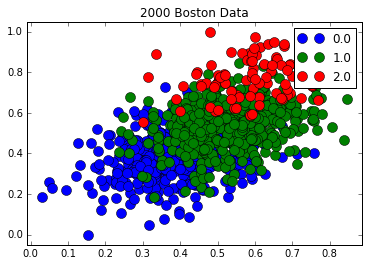

In [306]:
color=['red','blue','green']

groups = boston_df.groupby(2)

# Plot
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group[0], group[1], marker='o', linestyle='', ms=10, label=name)
ax.legend()
ax.set_title("2000 Boston Data")


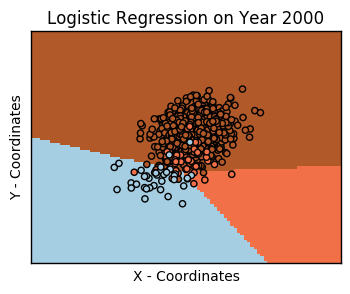

In [41]:
year_2000 = pd.read_csv('datasets\dataset_1_year_2000.txt', delimiter=' ',header=None)
X = pd.DataFrame.as_matrix(boston_df.ix[:,0:1])
Y = boston_df.ix[:,2]
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets

h = .02  # step size in the mesh

logreg = linear_model.LogisticRegression(C=1e5)

logreg.fit(X, Y)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('X - Coordinates')
plt.ylabel('Y - Coordinates')
plt.title('Logistic Regression on Year 2000')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [4]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      poly_flag (a boolean parameter, fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, poly_flag, title, ax):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='b')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='r')
    
    # Create mesh
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))
    
    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1)
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

C:\Users\mezot\Anaconda3\envs\Python27\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\mezot\Anaconda3\envs\Python27\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\mezot\Anaconda3\envs\Python27\lib\site-packages\sklearn\discriminant_analysis.py:457: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


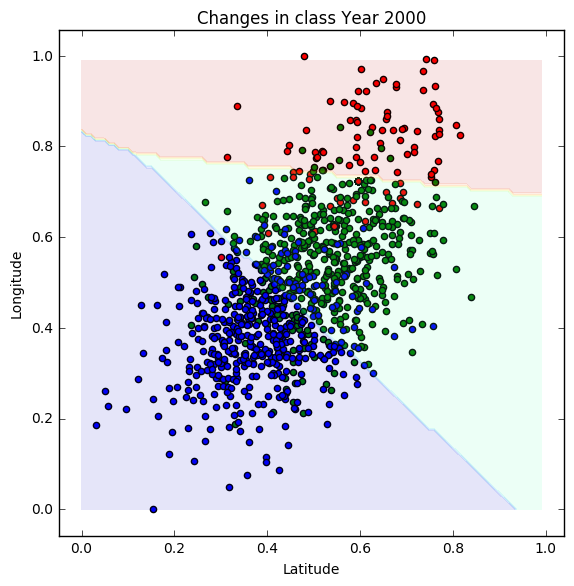

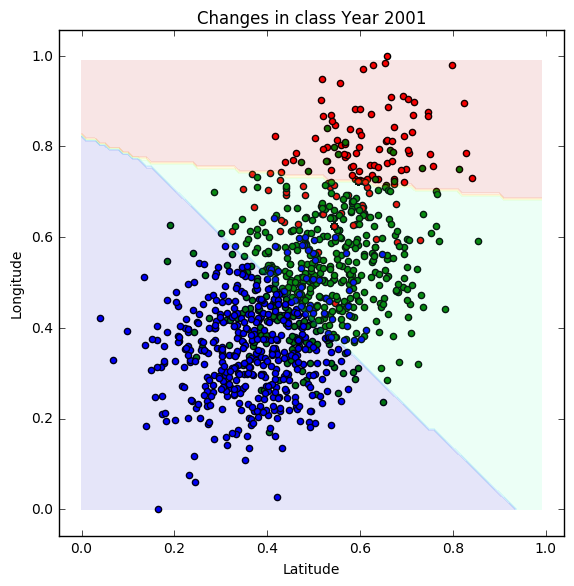

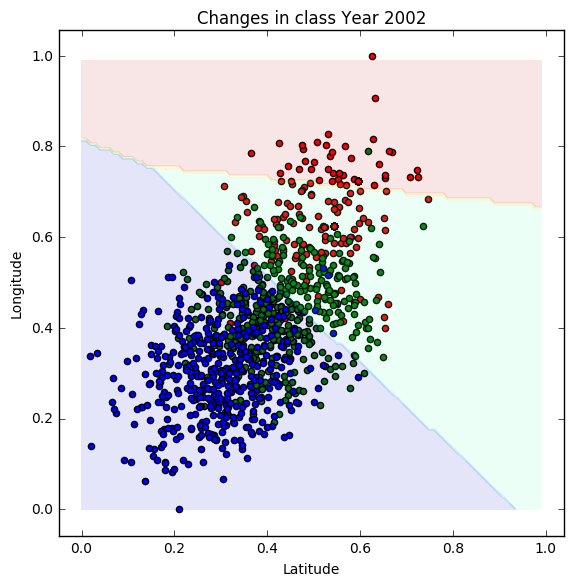

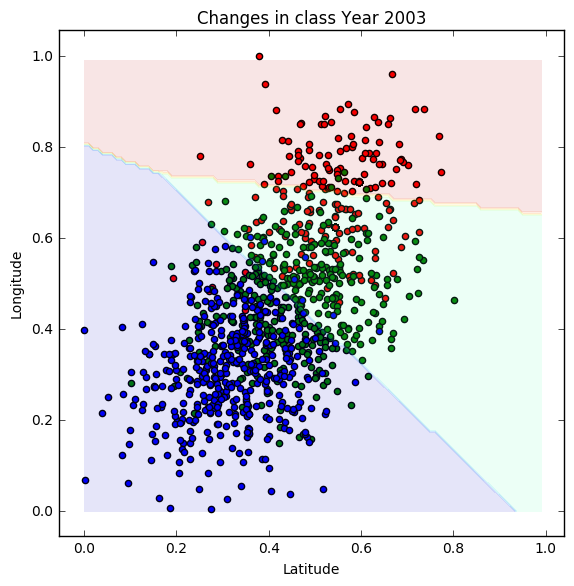

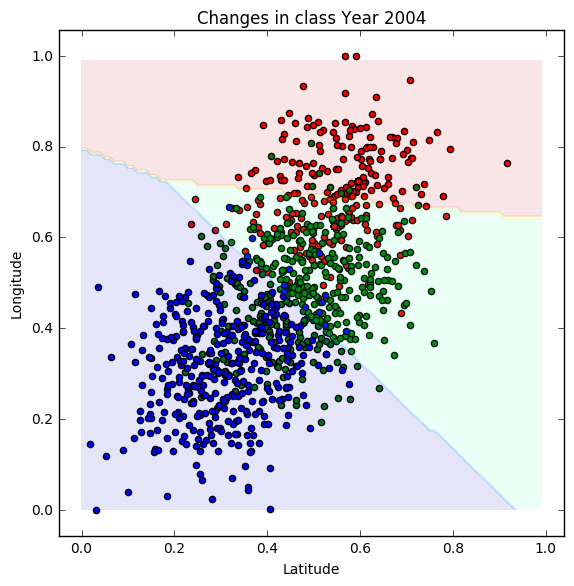

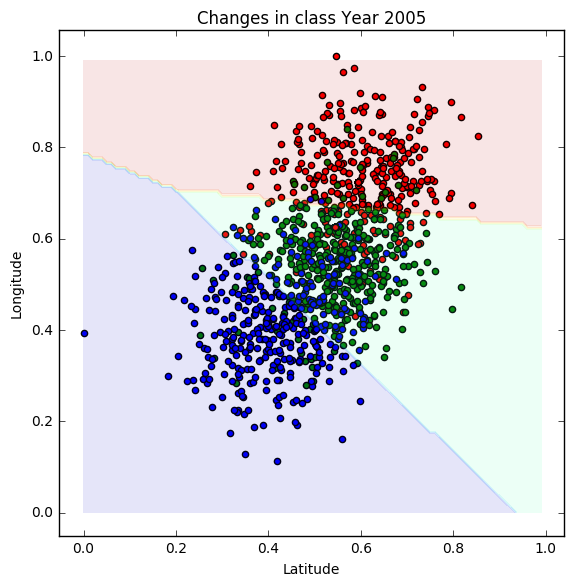

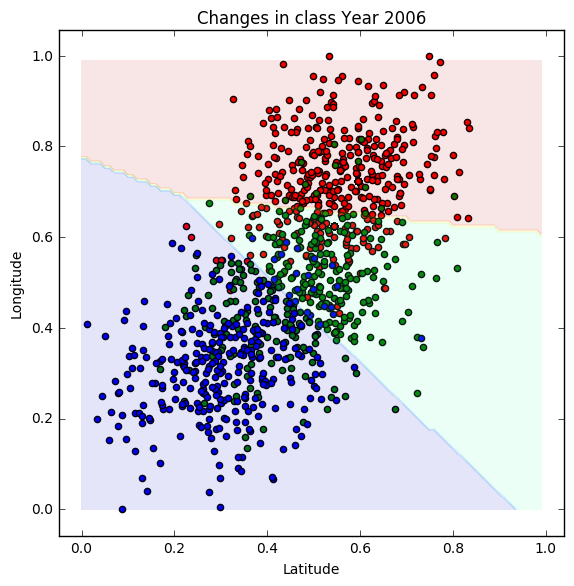

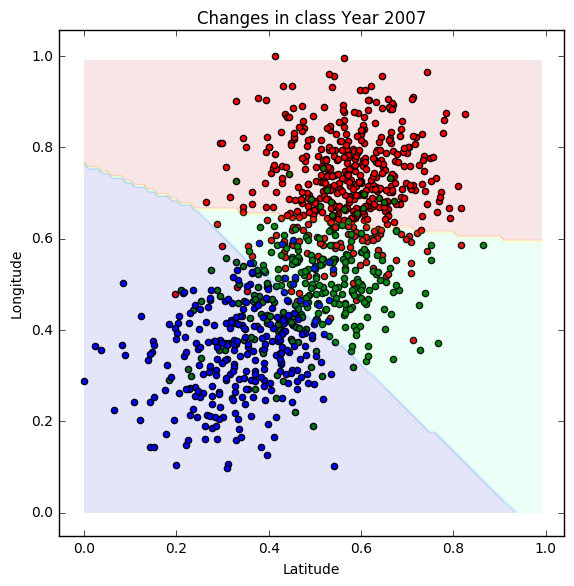

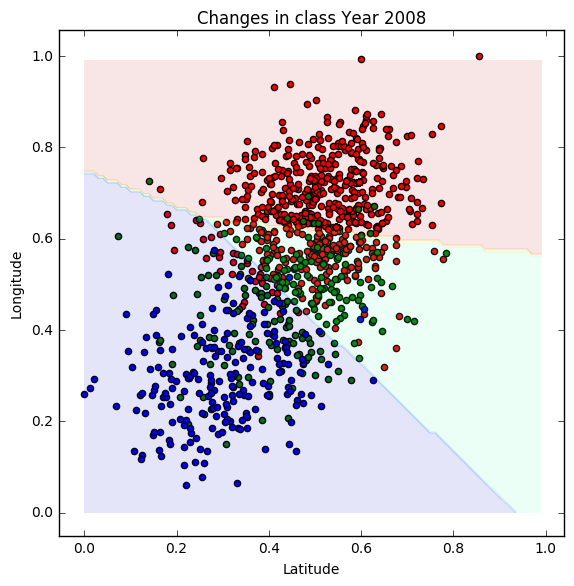

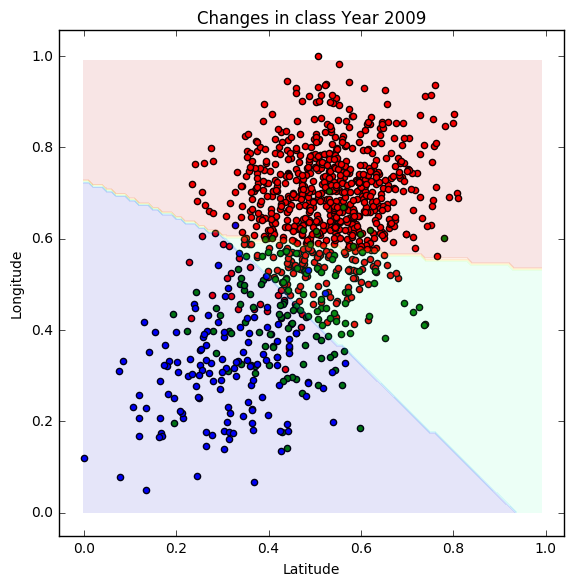

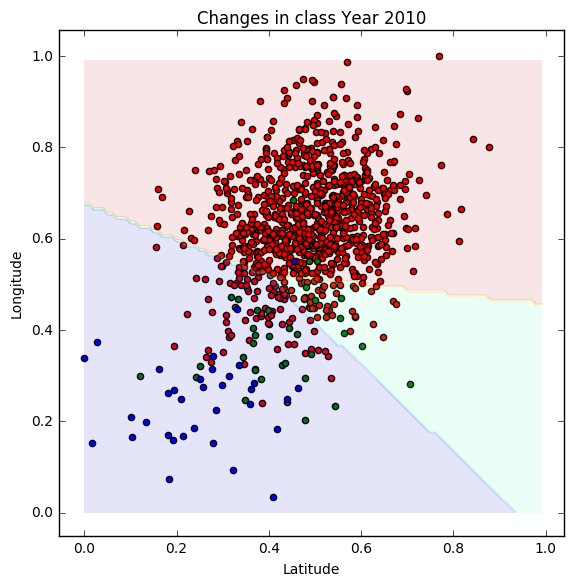

In [5]:
priors = []
scores = []
year_2000 = pd.read_csv('datasets\dataset_1_year_2000.txt', delimiter=' ',header=None)
for i in range(0,11):   
    if(i<10):
        boston_df = pd.read_csv('datasets\dataset_1_year_200'+str(i)+'.txt', delimiter=' ',header=None)
    else:
        boston_df = pd.read_csv('datasets\dataset_1_year_20'+str(i)+'.txt', delimiter=' ',header=None)
    X = pd.DataFrame.as_matrix(boston_df.ix[:,0:1])
    y = boston_df.ix[:,2]
 
    #gets count of each class
    zero = boston_df[y==0]
    zero = zero.ix[:,0:1]
    ones = boston_df[y==1]
    ones = ones.ix[:,0:1]
    twos = boston_df[y==2]
    twos = twos.ix[:,0:1]
    
    #divides class by count
    count_of_zero = zero.count(axis=0)[0]/1000.0
    count_of_ones = ones.count(axis=0)[0]/1000.0
    count_of_twos = twos.count(axis=0)[0]/1000.0

    #Always trains the LDA from year 2000 data
    X = pd.DataFrame.as_matrix(year_2000.ix[:,0:1])
    y = year_2000.ix[:,2]
    
    #Uses each years dataset to test and score
    X_test = pd.DataFrame.as_matrix(boston_df.ix[:,0:1])
    y_test = boston_df.ix[:,2]
    
    clf = LinearDiscriminantAnalysis(n_components=3, priors=[count_of_zero,count_of_ones,count_of_twos], shrinkage = None,
                  solver='svd', store_covariance=True, tol=0.0001)
    clf.fit(X, y) #Year 2000
    scores.append(clf.score(X_test,y_test)) #all other datasets

    priors.append(clf.priors_) #Save Priors
    fig1 = plt.figure(figsize=(30,30))


    ax = fig1.add_subplot(4,4, i+1)

    ax.scatter(twos[0],twos[1], c='r')
    ax.scatter(ones[0],ones[1], c='g')
    ax.scatter(zero[0],zero[1],c='b')
    if(i<10):
        ax = plot_decision_boundary(X,y,clf,0,'Changes in class Year 200'+str(i),ax)
    else:
        ax = plot_decision_boundary(X,y,clf,0,'Changes in class Year 20'+str(i),ax)

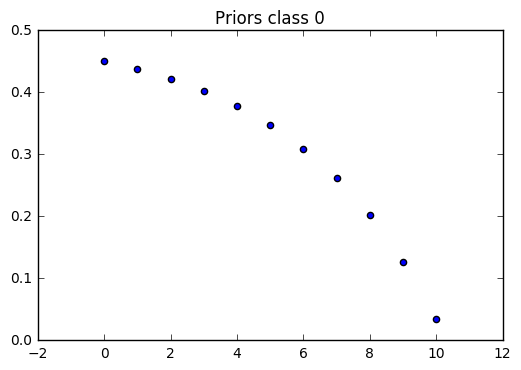

In [7]:
#Prior pattern

one = []
two = []
zero = []
for each in priors:
    one.append(each[1])
    two.append(each[2])
    zero.append(each[0])

plt.scatter(range(0,len(zero)),one)
plt.title('Priors class 0')

We can see that the Priors are constantly decreasing over the years for Class 0

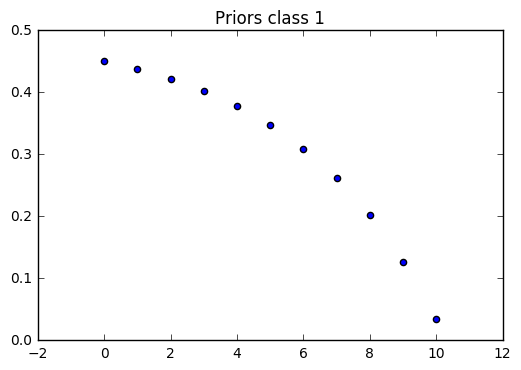

In [8]:
plt.scatter(range(0,len(one)),one)
plt.title('Priors class 1')

We can see that the Priors are constantly decreasing over the years for Class 1

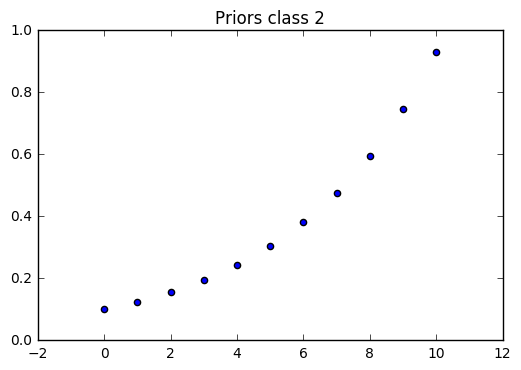

In [9]:
plt.scatter(range(0,len(two)),two)
plt.title('Priors class 2')


We can see that the Priors are constantly increasing over the years for Class 2

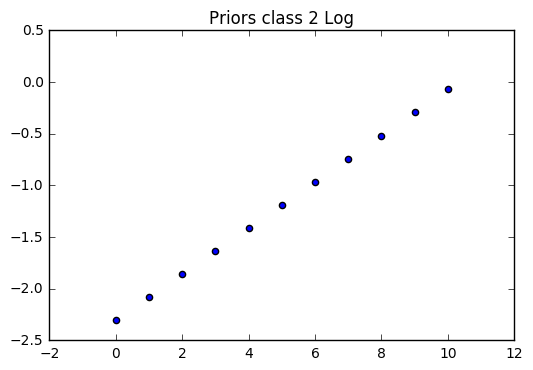

In [10]:
plt.scatter(range(0,len(two)),np.log(two))
plt.title('Priors class 2 Log')


This illustrates that the log(class2 priors) is clearly linearly growing

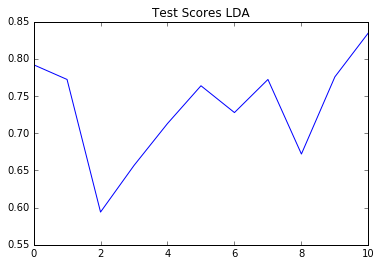

In [392]:
plt.plot(range(0,len(scores)),scores)
plt.title('Test Scores LDA')

By calculating the priors for each dataset from 2000-2010 and fitting the model from dataset_2000, with the priors, we can construct a fairly predictive model of each class.


2000-2010 was used as the test data to visualize the scoring of our model over the years.

Due to the population being predominantly Class 2 (High Class) in 2010, the model using estimatation priors of the future (>2010) will be mostly Class 2.

### Part 2(b): Geographic patterns in urban demographics

In `dataset_2.txt` and `dataset_3.txt` you have the demographic information for a random sample of houses in two regions in Cambridge. There are only two economic brackets for the households in these datasets: 

0: low-income or middle-class, 

1 - high-income. 

For each region, recommend a classification model, chosen from all the ones you have learned, that is most appropriate for classifying the demographics of households in the region.

**Hint:** Support your answers with both numerical and visual analysis.

In [12]:
cambridge_df1 = pd.read_csv('datasets\dataset_2.txt', delimiter=' ',header=None)
cambridge_df2 = pd.read_csv('datasets\dataset_3.txt', delimiter=' ',header=None)
print cambridge_df1.head()
print cambridge_df2.head()

          0         1    2
0  0.542866  0.433326  1.0
1  0.512297  0.491020  1.0
2  0.620624  0.303222  1.0
3  0.620553  0.478634  1.0
4  0.437379  0.418034  1.0
          0         1    2
0  0.126227  0.846415  1.0
1  0.115902  0.886631  1.0
2  0.139295  0.794580  1.0
3  0.123552  0.832449  1.0
4  0.163855  0.824699  1.0


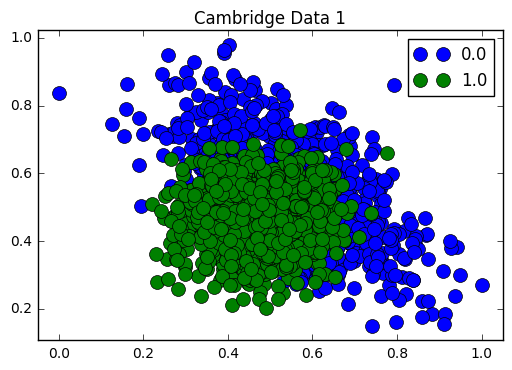

In [15]:
color=['red','blue','green']

groups = cambridge_df1.groupby(2)

# Plot
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group[0], group[1], marker='o', linestyle='', ms=10, label=name)
ax.legend()
ax.set_title("Cambridge Data 1")


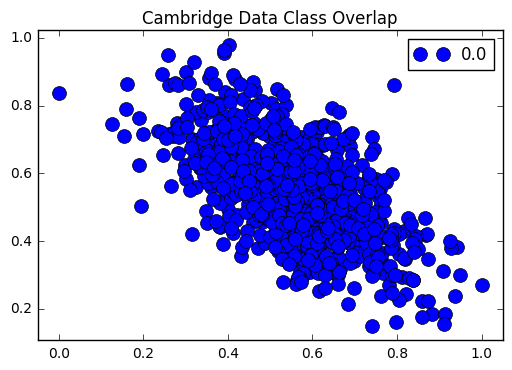

In [17]:
color=['red','blue','green']

groups = cambridge_df1.groupby(2)

# Plot
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    if(name<1):
        ax.plot(group[0], group[1], marker='o', linestyle='', ms=10, label=name)
ax.legend()
ax.set_title("Cambridge Data Class Overlap")

I chose to use Linear Discriminate Analysis as it was approriate to use, as the 2 classes overlap a large amount. The overall predictions should decrease to approximately 70% with LDA

LDA Scire
0.748


C:\Users\mezot\Anaconda3\envs\Python27\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\mezot\Anaconda3\envs\Python27\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


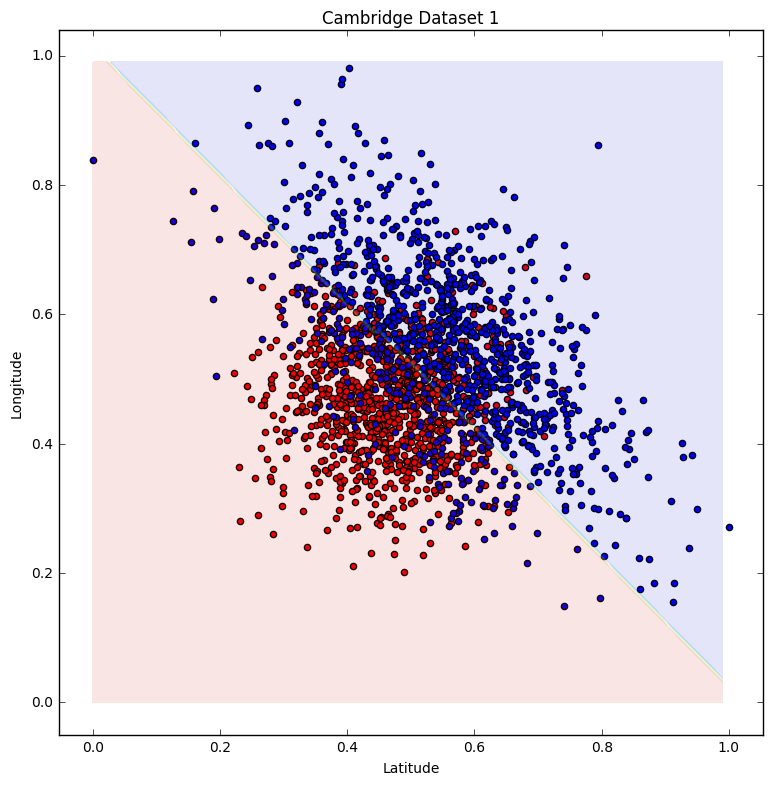

In [34]:
X = pd.DataFrame.as_matrix(cambridge_df1.ix[:,0:1])
y = cambridge_df1.ix[:,2]

from sklearn.neighbors import KNeighborsClassifier

clf = LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage = None,
                  solver='svd', store_covariance=True, tol=0.0001)
clf.fit(X, y) 
fig1 = plt.figure(figsize=(20,20))

zero = cambridge_df1[cambridge_df1[2]==0]
zero = zero.ix[:,0:1]
ones = cambridge_df1[cambridge_df1[2]==1]
ones = ones.ix[:,0:1]
print 'LDA Scire'
print clf.score(X,y)
ax = fig1.add_subplot(2,2, 1)
ax.scatter(ones[0],ones[1], c='r')
ax.scatter(zero[0],zero[1],c='b')
ax = plot_decision_boundary(X,y,clf,0,'Cambridge Dataset 1',ax)

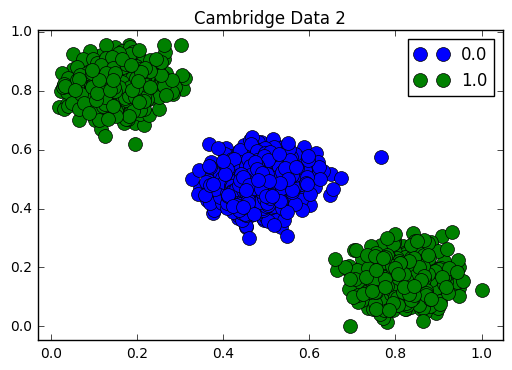

In [14]:
color=['red','blue','green']

groups = cambridge_df2.groupby(2)

# Plot
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group[0], group[1], marker='o', linestyle='', ms=10, label=name)
ax.legend()
ax.set_title("Cambridge Data 2")


I chose to use KNN for the second Cambridge dataset as the data is very well partitioned and should not suffer any loss for predictions.


KNN Score
1.0


C:\Users\mezot\Anaconda3\envs\Python27\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\mezot\Anaconda3\envs\Python27\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


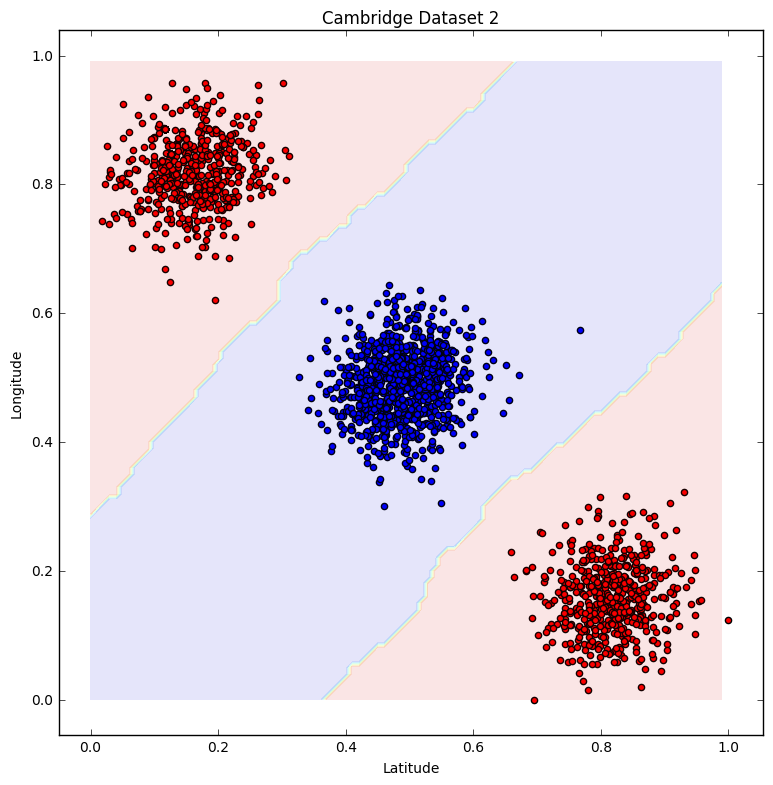

In [32]:
from sklearn.neighbors import KNeighborsClassifier

X = pd.DataFrame.as_matrix(cambridge_df2.ix[:,0:1])
y = cambridge_df2.ix[:,2]


neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y) 
fig1 = plt.figure(figsize=(20,20))

zero = cambridge_df2[cambridge_df2[2]==0]
zero = zero.ix[:,0:1]
ones = cambridge_df2[cambridge_df2[2]==1]
ones = ones.ix[:,0:1]

print 'KNN Score'
print neigh.score(X,y)

ax = fig1.add_subplot(2,2, 1)
ax.scatter(ones[0],ones[1], c='r')
ax.scatter(zero[0],zero[1],c='b')
ax = plot_decision_boundary(X,y,neigh,0,'Cambridge Dataset 2',ax)

---

## Challenge Problem: Regularization

We have seen ways to include different forms of regularizations in Linear regression and Logistic regression, in order to avoid overfitting. We will now explore ways to incorporate regularization within the discriminant analysis framework.

- When we have a small training sample, we end up with poor estimates of the class proportions $\pi_i$ and covariance matrices $\Sigma$. How can we regularize these quantities to improve the quality of the fitted model?


- We have seen that different assumptions on the covariance matrix results in either a linear or quadratic decision boundary. While the former may yield poor prediction accuracy, the latter could lead to over-fitting. Can you think of a suitable way to regularize the covariance to have an intermediate fit?

The solutions that you suggest must include a parameter that allows us to control the amount of regularization.

Be detailed in your explanation and support your reasoning fully. You do not, however, need to implement any of these solutions.